###🟢 Step 1 — Import libraries & define metric

In [2]:
# Import core libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Evaluation metric: Median Absolute Percentage Error
def mdape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true) * 100
    return np.median(ape)

### 🟢 Step 2 — Load datasets

In [4]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
census = pd.read_csv("census.csv")
# Print shapes to confirm files loaded correctly
print("Train:", train.shape)
print("Test:", test.shape)
print("Census:", census.shape)

Train: (46499, 14)
Test: (10325, 14)
Census: (2024, 7)


###🟢 Step 3 — Encode property_type & prepare baseline features

In [5]:
# Import label encoder to convert text categories into numeric form
from sklearn.preprocessing import LabelEncoder

# Create encoder object
enc = LabelEncoder()

# Fit encoder on property_type column and convert it into numbers in train data
train["property_type_enc"] = enc.fit_transform(train["property_type"])

# Apply same encoding to test data to keep mapping consistent
test["property_type_enc"] = enc.transform(test["property_type"])

# Define list of features used in the baseline model (without census)
baseline_features = [
    "latitude",
    "longitude",
    "sqft",
    "beds",
    "baths",
    "property_type_enc",
    "days_since_2014"
]

# Target column to predict — already log-transformed and normalized
target_col = "trans_log_price"

# Extract feature columns for training and test inputs
X_train_base = train[baseline_features]
X_test_base  = test[baseline_features]

# Extract target values for training and testing
y_train = train[target_col]
y_test  = test[target_col]

# Confirm matrices were created successfully
print("Baseline matrices ready:", X_train_base.shape, X_test_base.shape)

Baseline matrices ready: (46499, 7) (10325, 7)


### 🟢 Step 4 — Train & evaluate BASELINE model

In [6]:
# Create baseline XGBoost regression model with fixed hyperparameters
baseline_model = XGBRegressor(
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model on baseline features and training target values
baseline_model.fit(X_train_base, y_train)

# Generate predictions on test dataset features
y_pred_base = baseline_model.predict(X_test_base)

# Compute MdAPE metric for baseline model
baseline_mdape = mdape(y_test, y_pred_base)

# Print performance result
print("Baseline MdAPE:", baseline_mdape)

Baseline MdAPE: 38.69357283150387


### 🟢 Step 5 — Merge Census Data & Prepare Enhanced Features

In [7]:
# keep latest census record per blockgroup
census_unique = (
    census.sort_values("year")
          .drop_duplicates("blockgroup", keep="last")
)

# merge census to train
train_c = train.merge(
    census_unique[["blockgroup","population","housing","education","transportation"]],
    on="blockgroup",
    how="left"
)

# merge census to test
test_c = test.merge(
    census_unique[["blockgroup","population","housing","education","transportation"]],
    on="blockgroup",
    how="left"
)

# enhanced feature list
enhanced_features = baseline_features + [
    "population","housing","education","transportation"
]

# build matrices
X_train_enh = train_c[enhanced_features]
X_test_enh  = test_c[enhanced_features]

print("Enhanced shapes:", X_train_enh.shape, y_train.shape)

Enhanced shapes: (46499, 11) (46499,)


### 🟢 Step 6 — Train & evaluate enhanced model

In [8]:
# enhanced model (same parameters as baseline)
enh_model = XGBRegressor(
    max_depth=6,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# train on enhanced features
enh_model.fit(X_train_enh, y_train)

# predict & evaluate
y_pred_enh = enh_model.predict(X_test_enh)
enh_mdape = mdape(y_test, y_pred_enh)

print("Enhanced MdAPE:", enh_mdape)

Enhanced MdAPE: 40.478970304670334


### 🟢 Step 7 — Compare both models

In [9]:
# Compare performance
improvement = baseline_mdape - enh_mdape
print("Improvement:", improvement)

Improvement: -1.7853974731664621


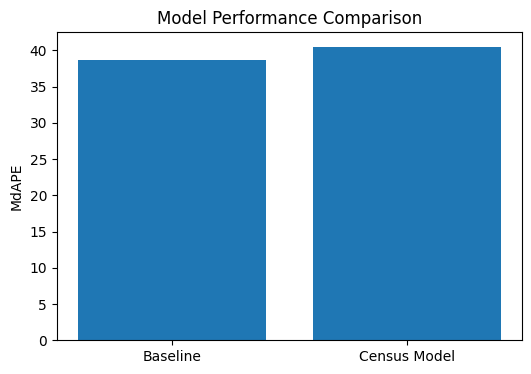

In [10]:
# compare baseline vs census model MdAPE (bar chart)
import matplotlib.pyplot as plt

labels = ["Baseline", "Census Model"]
values = [baseline_mdape, enh_mdape]
# Ploting Bar Chart
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("MdAPE")
plt.title("Model Performance Comparison")
plt.show()


In [12]:
# Save experiment comparison file
import json

results = {
    "experiment_name": "baseline_vs_census",
    "dataset_used": "train.csv / test.csv",
    "baseline_features": "property_only",
    "enhanced_features": "property_plus_census",

    "baseline_mdape": float(baseline_mdape),
    "census_mdape": float(enh_mdape),
    "improvement_delta": float(baseline_mdape - enh_mdape),

    "model_type": "xgboost",
    "status": "census_helped" if enh_mdape < baseline_mdape else "census_did_not_help"
}

with open("model_comparison_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Comparison file saved → model_comparison_results.json")
print(results)


Comparison file saved → model_comparison_results.json
{'experiment_name': 'baseline_vs_census', 'dataset_used': 'train.csv / test.csv', 'baseline_features': 'property_only', 'enhanced_features': 'property_plus_census', 'baseline_mdape': 38.69357283150387, 'census_mdape': 40.478970304670334, 'improvement_delta': -1.7853974731664621, 'model_type': 'xgboost', 'status': 'census_did_not_help'}


### 🟢 Step 8 — Save baseline model

In [11]:
import joblib
joblib.dump(baseline_model, "beekin_model_baseline.pkl")
print("baseline model saved")

baseline model saved
